# Data Gathering and Storage from Twitter
## Authors

 - Santiago Bernal

## Introduction
In this lab exercise, data is gathered from twitter using different hashtags using the Twitter Developer API. The data is then stored in a MongoDB database for later retrieval and analysis. The exercise was developed in Python using Jupyter Notebooks.


## Excercise
### First experiment
For the first experiment made, hashtags that were trending globally where used: 
``` ['#FelizMartes','#paro', '#TuesdayMotivation', '#GuyFawkesNight', '#amazon', '#Marvel', '#StillHereForWonho', '#WayV_LoveTalk', '#MardiConseil', '#WhatNotToWearAtWalmart']```
Looking at the tweets, some of them like 'FelizMartes' and 'paro' were from Spanish speaking countries, the first one related to the day the tweets were captured, and the second related to a news article in Spain. Others like 'TuesdayMotivation', 'amazon', 'marvel', 'WhatNotToWearAtWalmart' where mostly trending in the US. 'GuyFawkesNight' was trending in the US as well as in the UK. 'MardiConseil' was a hashtag mostly used in France, also related to that it was Tuesday. 'StillHereForWonho' was related to the news of K-pop star Wonho leaving a band called Monsta X. WayV_LoveTalk was also related to K-pop, based on a song released by artist WayV.

To be able to extract the hashtags we first setup the access keys to use with the Twitter API (removed for security purposes): 

In [42]:
from __future__ import print_function
import tweepy
import json
from pymongo import MongoClient
# assuming you have mongoDB installed locally
# and a database called 'test'
MONGO_HOST= 'mongodb://localhost/bda1'
WORDS = ['#FelizMartes','#paro', '#TuesdayMotivation', '#GuyFawkesNight', '#amazon', '#Marvel', '#StillHereForWonho', '#WayV_LoveTalk', '#MardiConseil', '#WhatNotToWearAtWalmart'] #This is an OR relation
CONSUMER_KEY = "CONSUMER_KEY"
CONSUMER_SECRET = "CONSUMER_SECRET"
ACCESS_TOKEN = "ACCESS_TOKEN"
ACCESS_TOKEN_SECRET = "ACCESS_TOKEN_SECRET"

We then define our stream listener that will listen for new tweets made with the hashtags that we defined, and then store them in a MongoDB collection. The data is transformed into json and stored directly into the database, so no fields are missing in case we want to perform further analysis. 

In [4]:
class StreamListener(tweepy.StreamListener):    
    #This is a class provided by tweepy to access the Twitter Streaming API. 

    def on_connect(self):
        # Called initially to connect to the Streaming API
        print("You are now connected to the streaming API.")
 
    def on_error(self, status_code):
        # On error - if an error occurs, display the error / status code
        print('An Error has occured: ' + repr(status_code))
        return False
 
    def on_data(self, data):
        #This is the meat of the script...it connects to your mongoDB and stores the tweet
        try:
            client = MongoClient(MONGO_HOST)
            
            # Use test database. If it doesn't exist, it will be created.
            db = client.lab1
    
            # Decode the JSON from Twitter
            datajson = json.loads(data)
            
            #grab the 'created_at' data from the Tweet to use for display
            created_at = datajson['created_at']
            username = datajson['user']['screen_name']

            #print out a message to the screen that we have collected a tweet
            #print("Tweet collected at " + str(created_at) + " from user @" + username)
            
            #insert the data into the mongoDB into a collection called twitter_search
            #if twitter_search doesn't exist, it will be created.
            db.twitterTest.insert(datajson)
        except Exception as e:
            print(e)

We use tweepy to build the required authentication object and setup the listener defined previously. We use the wait_on_rate_limit set to TRUE so that on exceeding the rate limit, the listener waits until we can continue searching for tweets. We then use a tweepy streamer object to access the streams and we add the defined hashtags as filters so that we only capture tweets we are interested in. 

In [5]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
#Set up the listener. The 'wait_on_rate_limit=True' is needed to help with Twitter API rate limiting.
listener = StreamListener(api=tweepy.API(wait_on_rate_limit=True))
streamer = tweepy.Stream(auth=auth, listener=listener)
#print("Tracking: " + str(WORDS))
streamer.filter(track=WORDS)

After leaving the streamer capture data for a while, we can see how many tweets we where able to store:

In [43]:
from __future__ import division
from pymongo import MongoClient
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import operator

# Establish connection with database
client = MongoClient()
db = client.lab1
col = db.twitterTest

print('Total tweets captured: ', col.count_documents(filter={}))

Total tweets captured:  106018


We retrieve the tweets with only the data that we will use:

In [44]:
#######################################################
# Retrieve data from the mongodb database, choosing
# the fields you'll need afterwards
#######################################################
my_tweets = db.twitterTest.find({},{'lang':1, '_id':0, 'text':1, 'entities.hashtags':1,
'in_reply_to_status_id':1, 'is_quote_status':1, 'retweeted_status':1, 'user.screen_name':1, 
'entities.user_mentions': 1, 'place': 1, '_id': 1})
numTweets = db.twitterTest.count_documents(filter={})

We plot the data using different criteria to better understand what we where able to capture.

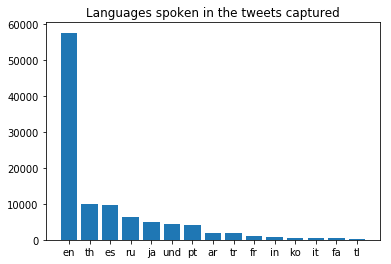

In [45]:
####################################################
# Plot of Languages (autodetected by Twitter)
####################################################
my_tweets.rewind()
langsList = []
for t in my_tweets:
    langsList.append(t['lang'])

D = Counter(langsList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))
# ----------- Bar Plot ------------------------
plt.bar(range(len(subset)), list(subset.values()), align='center')
plt.xticks(range(len(subset)), subset.keys())
plt.title('Languages spoken in the tweets captured')
plt.show()


Using the 'lang' field provided by twitter, which gives the language that twitter detects the tweet was in, shows a vast majority of tweets in english, even though some Spanish hashtags were used, it ties in second with Thai. Few tweets were in Korean and French languages, also included in the hashtags used. Weird enough, russian is the third language captured, and none of the hashtags used were in russian

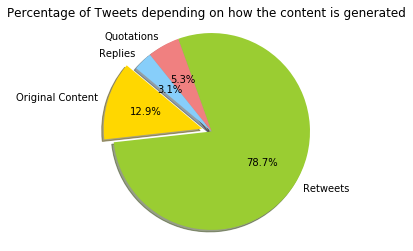

In [46]:
##############################################################
# Plot how many of them are retweets, replies,
# quotations or original tweets
##############################################################
my_tweets.rewind() #Reset cursor
retweets = 0
replies = 0
quotations = 0
originals = 0
for t in my_tweets:
    if t.get('retweeted_status') is not None:
        retweets=retweets+1
    elif t['is_quote_status'] is not False:
        quotations = quotations+1
    elif t.get('in_reply_to_status_id') is not None:
        replies = replies+1
    else:
        originals = originals+1

# ----------- Pie Chart ------------------------
labels = 'Original Content', 'Retweets', 'Quotations', 'Replies'
sizes = [originals, retweets, quotations, replies]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets depending on how the content is generated')
plt.show()


Tweets can be generated in different ways, they can be directly tweeted by the user and then have replies or retweets. Users can also quote other tweets and add their own remarks. Of the data collected, most of them were retweets, and only a 13% were original content. 

Additionally, we can check which hashtags were the most captured, including not only the hashtags we filtered but also any aditional hashtag that the tweets have. 

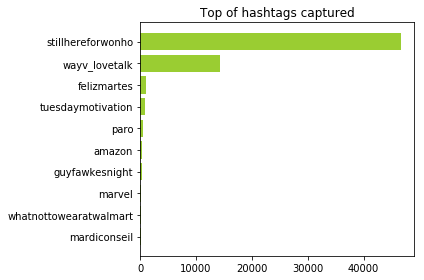

In [141]:
##################################################################
# Plot only filtered hashtags
##################################################################
my_tweets.rewind()
hashList = [] 
words_lower = ['felizmartes','#paro', '#tuesdaymotivation', '#guyfawkesnight', '#amazon', '#marvel', '#stillhereforwonho', '#wayv_lovetalk', '#mardiconseil', '#whatnottowearatwalmart'] 
for t in my_tweets:
    for e in t['entities']['hashtags']:
        if '#' + e['text'].lower() in words_lower or e['text'].lower() in words_lower:
            h = e['text'].lower()
            hashList.append(h)
D = Counter(hashList)
subset = dict(D)
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'yellowgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top of hashtags captured')
plt.tight_layout()
plt.show()


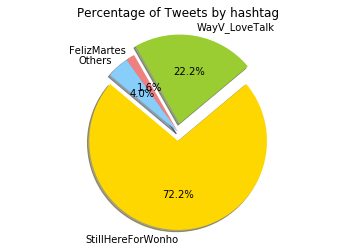

In [142]:
# ----------- Pie Chart ------------------------
others = len(hashList) - subset['stillhereforwonho'] - subset['wayv_lovetalk'] - subset['felizmartes']
labels = 'StillHereForWonho', 'WayV_LoveTalk', 'FelizMartes', 'Others'
sizes = [subset['stillhereforwonho'], subset['wayv_lovetalk'], subset['felizmartes'], others]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0.1, 0, 0)  
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets by hashtag')
plt.show()

So of the hashtags used, most of the tweets captured are those related to K-pop, with StillHereForWonho getting the vast majority of the tweets with 72%, WayV_LoveTalk with 22% and the rest only a 5%.

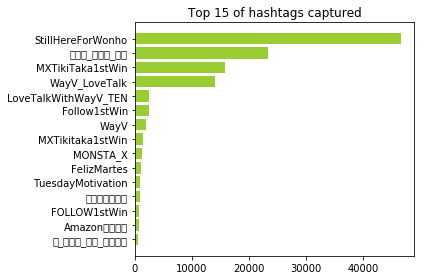

In [143]:
##################################################################
# Plot secondary hashtags
##################################################################


my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['hashtags']:
        h = e['text']
#         if not is_ascii(h):
#             h=asd
        hashList.append(h)
D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'yellowgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags captured')
plt.tight_layout()
plt.show()

Looking at the amount of hashtags also considering any secondary hashtags we can see that other hashtags were more common than the ones we defined, that were used in conjunction probably with the K-pop related hashtags. Some of the hashtags use asian characters which we couldn't get to show clearly on the graph but these are: '절대로_포기는_안해', 'おそうじシュシュ' (never give up), 'プレゼント企画' (present plan), 'Amazonギフト券' (amazon gift card), and '긴_싸움을_위해_준비됐다' (ready for a long fight). Using these hashtags we can see which is the mayority of hashtags found

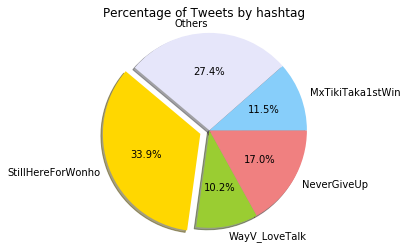

In [150]:
wonho = 0
wayv = 0
never = 0
mx = 0
others = 0
for h in hashList:
    if h =='StillHereForWonho':
        wonho=wonho+1
    elif h =='WayV_LoveTalk': 
        wayv=wayv+1
    elif h=='절대로_포기는_안해':
        never=never+1
    elif h=='MXTikiTaka1stWin':
        mx=mx+1
    else:
        others=others+1
# ----------- Pie Chart ------------------------
labels = 'StillHereForWonho', 'WayV_LoveTalk', 'NeverGiveUp', 'MxTikiTaka1stWin', 'Others'
sizes = [wonho, wayv, never, mx, others]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lavender']
explode = (0.1, 0, 0, 0, 0)  
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets by hashtag')
plt.show()

So if we look at other hashtags included, StillHereForWonho still has the majority, but other hashtags are also able to obtain high values, with '절대로_포기는_안해', 'おそうじシュシュ' (never give up) being the second with 17%. We can also group some of the most common hashtags, considering that they relate to the same topic. So we can group StillHereForWonho and MONSTA_X since they both relate to the K-pop band, and we can group WayV_LoveTalk, WayV and LoveTalkWithWayV_TEN for the release of the K-pop song. 

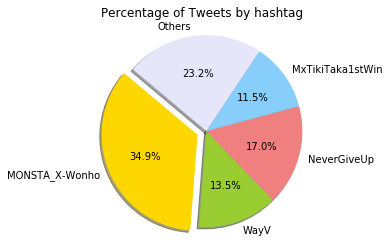

In [152]:
wonho = 0
wayv = 0
never = 0
mx = 0
others = 0
for h in hashList:
    if h =='StillHereForWonho' or h=='MONSTA_X':
        wonho=wonho+1
    elif h =='WayV_LoveTalk' or h=='WayV' or h=='LoveTalkWithWayV_TEN': 
        wayv=wayv+1
    elif h=='절대로_포기는_안해':
        never=never+1
    elif h=='MXTikiTaka1stWin':
        mx=mx+1
    else:
        others=others+1
# ----------- Pie Chart ------------------------
labels = 'MONSTA_X-Wonho', 'WayV', 'NeverGiveUp', 'MxTikiTaka1stWin', 'Others'
sizes = [wonho, wayv, never, mx, others]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lavender']
explode = (0.1, 0, 0, 0, 0)  
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets by hashtag')
plt.show()

Unfortunately, not all tweets retrieved have location enabled, making it hard to determine the popularity in each country for the hashtags. Still a few amount did have the location included so we can determine, of the subset that has it, the countries where some of the hashtags originated

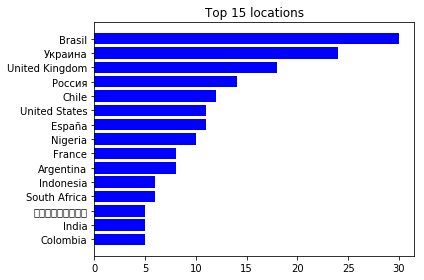

In [153]:
##################################################################
# Plot most common countries
##################################################################
my_tweets.rewind()
geo = []
for t in my_tweets:
    if t['place']: 
        geo.append(t['place']['country'])

D = Counter(geo)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'blue')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 locations')
plt.tight_layout()
plt.show()
#print('amount: ', len(geo))

The results are surprising considering that even though most of the hashtags where from US, UK, Korea and Spain, the country with most tweets is Brazil and followed by Ukraine. But this also makes sense since only a small part of the tweets have location available.

We can also look at users mentioned in the tweets, which allows us to see which users influenced these trending topics. 

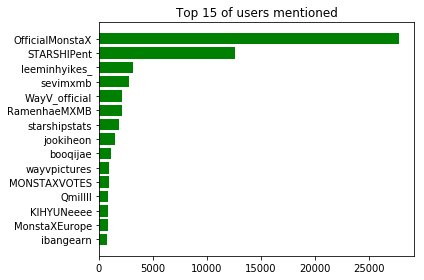

In [12]:
##################################################################
# Plot users mentioned
##################################################################
my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        h = e['screen_name']
        hashList.append(h)
D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset)) 
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'green')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned')
plt.tight_layout()
plt.show()

The user that is mostly mentioned is OfficalMonstaX which is the main account of MonstaX, the Kpop band related to the StillHereForWonho hashtag, so it makes sense that its the highest mentioned, also some fan accounts like MONSTAXVOTES and MonstaXEurope, and STARSHIPent which is for Starship Entertainment which is the record label to MonstaX. So the mayority of users are related to the highest used hashtag which was StillHereForWonho.

### Second experiment
The first experiment was heavily influenced by trending topics in K-pop, considering this, a second experiment was performed to analyse hashtags that weren't related to the genre. For this, the following words were used: 

```['#FelizMartes','#ChernobylSky', '#paro', '#PorTuCaraDeMartes', '#TuesdayThoughts', '#5Nov', '#primerapagina', '#SomosTodosAllan', '#BuenMartes', '#UltimaHora', '#Ahora', '#ElectionDay', '#TuesdayMorning', '#DebateElectoral']```

We repeat some of the previous hashtags like FelizMartes and paro and add a few others related to the day: TuesdayThoughts, 5Nov, BuenMartes, TuesdayMorning. Also it was the same day as a debate in Spain so DebateElectoral was trending and also ElectionDay since there was an election in the US. Some other stuff related to news are: UltimaHora, Ahora and SomosTodosAllan. The last one relates to users expressing support to a journalist in Brazil. 


In [154]:
WORDS = ['#FelizMartes','#ChernobylSky', '#paro', '#PorTuCaraDeMartes', '#TuesdayThoughts', '#5Nov', '#primerapagina', '#SomosTodosAllan', '#BuenMartes', '#UltimaHora', '#Ahora', '#ElectionDay', '#TuesdayMorning', '#DebateElectoral'] #This is an OR relation

As before we create the stream listener, but this time we change the collections so that we can separate each search. Then we listen to the twitter API and then search for the tweets in the database.

In [14]:
class StreamListener2(tweepy.StreamListener):    
    #This is a class provided by tweepy to access the Twitter Streaming API. 

    def on_connect(self):
        # Called initially to connect to the Streaming API
        print("You are now connected to the streaming API.")
 
    def on_error(self, status_code):
        # On error - if an error occurs, display the error / status code
        print('An Error has occured: ' + repr(status_code))
        return False
 
    def on_data(self, data):
        #This is the meat of the script...it connects to your mongoDB and stores the tweet
        try:
            client = MongoClient(MONGO_HOST)
            
            # Use test database. If it doesn't exist, it will be created.
            db = client.lab1
    
            # Decode the JSON from Twitter
            datajson = json.loads(data)

            db.twitterTest2.insert(datajson)
        except Exception as e:
            print(e)

In [15]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
#Set up the listener. The 'wait_on_rate_limit=True' is needed to help with Twitter API rate limiting.
listener = StreamListener2(api=tweepy.API(wait_on_rate_limit=True))
streamer = tweepy.Stream(auth=auth, listener=listener)
#print("Tracking: " + str(WORDS))
streamer.filter(track=WORDS)

In [155]:
# Establish connection with database
client = MongoClient()
db = client.lab1
col2 = db.twitterTest2

In [156]:
#######################################################
# Retrieve data from the mongodb database, choosing
# the fields you'll need afterwards
#######################################################
my_tweets = db.twitterTest2.find({},{'lang':1, '_id':0, 'text':1, 'entities.hashtags':1,
'in_reply_to_status_id':1, 'is_quote_status':1, 'retweeted_status':1, 'user.screen_name':1, 
'entities.user_mentions': 1, 'place': 1, '_id': 1})
numTweets = db.twitterTest.count_documents(filter={})

The total number of tweets that were able to be retrieve are: 

In [159]:
print('Number of tweets: ', numTweets)

Number of tweets:  106018


After collecting the tweets, we then compare them based on the language detected by twitter:

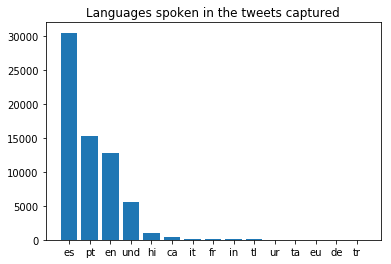

In [157]:
####################################################
# Plot of Languages (autodetected by Twitter)
####################################################
my_tweets.rewind()
langsList = []
for t in my_tweets:
    langsList.append(t['lang'])

D = Counter(langsList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))
# ----------- Bar Plot ------------------------
plt.bar(range(len(subset)), list(subset.values()), align='center')
plt.xticks(range(len(subset)), subset.keys())
plt.title('Languages spoken in the tweets captured')
plt.show()

In this case, most of the tweets were in spanish which makes sense because most of the hashtags used were in spanish. Also a large amount of them were in portuguese which may relate to the SomosTodosAllan hashtag. Coming in third are tweets in english, and then a large amount have undefined language. 

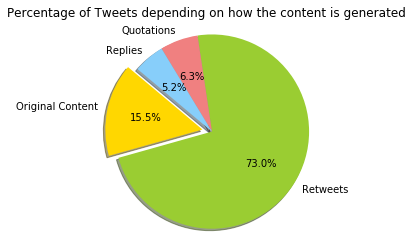

In [158]:
##############################################################
# Plot how many of them are retweets, replies,
# quotations or original tweets
##############################################################
my_tweets.rewind() #Reset cursor
retweets = 0
replies = 0
quotations = 0
originals = 0
for t in my_tweets:
    if t.get('retweeted_status') is not None:
        retweets=retweets+1
    elif t['is_quote_status'] is not False:
        quotations = quotations+1
    elif t.get('in_reply_to_status_id') is not None:
        replies = replies+1
    else:
        originals = originals+1

# ----------- Pie Chart ------------------------
labels = 'Original Content', 'Retweets', 'Quotations', 'Replies'
sizes = [originals, retweets, quotations, replies]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets depending on how the content is generated')
plt.show()

As with before, most of the content was generated by retweets. 

We can then check which hashtag was the most popular of the tweets retrieved

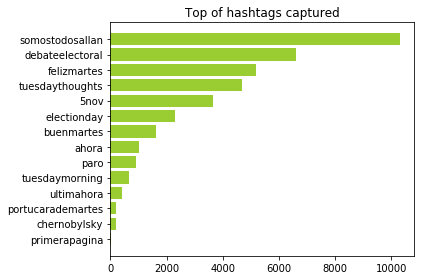

In [160]:
##################################################################
# Plot only filtered hashtags
##################################################################
my_tweets.rewind()
hashList = [] 
words_lower = ['#felizmartes','#paro', '#chernobylsky', '#portucarademartes', '#tuesdaythoughts', '#5nov', '#primerapagina', '#somostodosallan', '#buenmartes', '#ultimahora', '#ahora', '#electionday', '#tuesdaymorning', '#debateelectoral'] 
for t in my_tweets:
    for e in t['entities']['hashtags']:
        if '#' + e['text'].lower() in words_lower or e['text'].lower() in words_lower:
            h = e['text'].lower()
            hashList.append(h)
D = Counter(hashList)
subset = dict(D)
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'yellowgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top of hashtags captured')
plt.tight_layout()
plt.show()

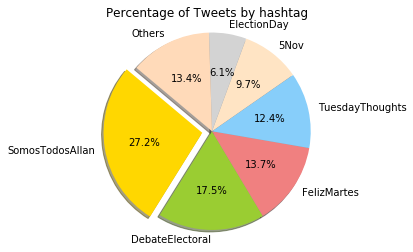

In [163]:
# ----------- Pie Chart ------------------------
others = len(hashList) - subset['somostodosallan'] - subset['debateelectoral'] - subset['felizmartes'] - subset['tuesdaythoughts'] - subset['5nov'] - subset['electionday']
labels = 'SomosTodosAllan', 'DebateElectoral', 'FelizMartes', 'TuesdayThoughts', '5Nov', 'ElectionDay', 'Others'
sizes = [subset['somostodosallan'], subset['debateelectoral'], subset['felizmartes'], subset['tuesdaythoughts'], subset['5nov'], subset['electionday'], others]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'bisque', 'lightgrey', 'peachpuff']
explode = (0.1, 0, 0, 0, 0, 0 ,0)  
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets by hashtag')
plt.show()

So the mayority of tweets was with #SomosTodosAllan which represents a 27.2% but now we have a better distribution since the second is #DebateElectoral with 17.5%, and FelizMartes and TuesdayThoughts with 13.7% and 12.4% respectively. 

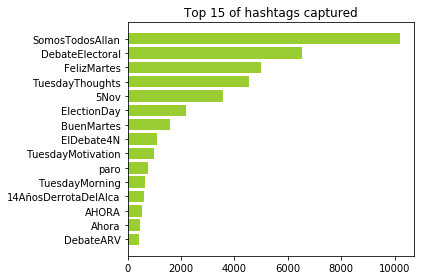

In [164]:
##################################################################
# Plot secondary hashtags
##################################################################
my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['hashtags']:
        h = e['text']
        hashList.append(h)
D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'yellowgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags captured')
plt.tight_layout()
plt.show()

This time, the secondary hashtags weren't as much as in the previous case and the hashtags filtered still remained as the top hashtags captured.

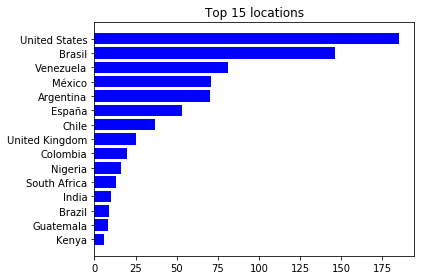

In [23]:
##################################################################
# Plot most common countries
##################################################################
my_tweets.rewind()
geo = []
for t in my_tweets:
    if t['place']: 
        geo.append(t['place']['country'])

D = Counter(geo)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'blue')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 locations')
plt.tight_layout()
plt.show()

This time, more tweets had locations included, and the top countries are the US, Brazil and Venezuela. We can look a bit more into this and see which hashtags are popular in each of these top countries 

In [165]:
##################################################################
# Plot countries by hashtags
##################################################################
my_tweets.rewind()
data = []
for t in my_tweets:
    for e in t['entities']['hashtags']:
        if t['place']: 
            d = {'hashtag': e['text'], 'country': t['place']['country']}
            data.append(d)

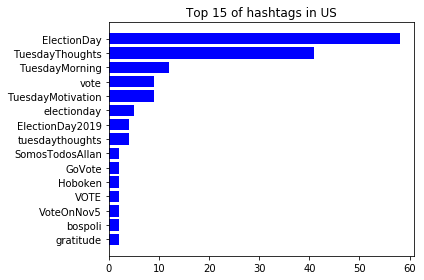

In [166]:
us = []
for d in data:
    if d['country'] == 'United States':
        us.append(d['hashtag'])

D = Counter(us)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'blue')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags in US')
plt.tight_layout()
plt.show()

In the US, the most popular hashtag, amongst the tweets that have the location, are the ones in english, with the top one being ElectionDay which was a current event that was transcurring that day, also other variations such as vote, electionday, ElectionDay2019, GoVote, VOTE, VoteOnNov5 were amongst the top 15. The other top are mostly based on the day Tuesday, and a few also related to SomosTodosAllan. 

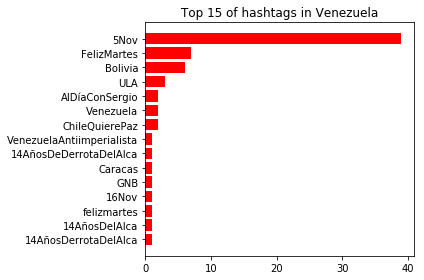

In [167]:
vzla = []
for d in data:
    if d['country'] == 'Venezuela':
        vzla.append(d['hashtag'])

D = Counter(vzla)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'red')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags in Venezuela')
plt.tight_layout()
plt.show()

In Venezuela, the most used hashtag was 5Nov by vast majority, and the rest have only a few tweets related. 

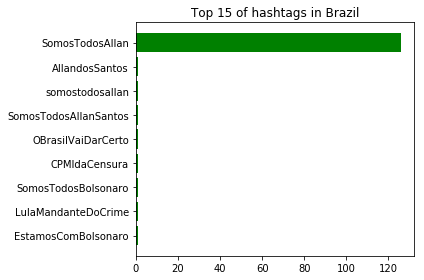

In [191]:
brazil = []
for d in data:
    if d['country'] == 'Brasil':
        brazil.append(d['hashtag'])

D = Counter(brazil)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'green')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags in Brazil')
plt.tight_layout()
plt.show()

Brazils hashtag was largely dominated by SomosTodosAllan, which makes sense since it was a news that was transcurring in Brazil at the moment. 

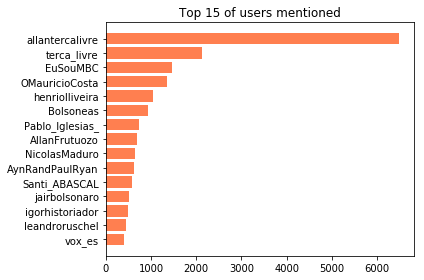

In [169]:
##################################################################
# Plot users mentioned
##################################################################
my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        h = e['screen_name']
        hashList.append(h)
D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'coral')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned')
plt.tight_layout()
plt.show()

Out of the users mentioned, most are also related with the hashtags, for example allantercalivre and terca_livre are related to SomosTodosAllan, since they're the media companies that Allan works in. EuSouMBC is a political party in Brazil, and Bolsoneas, OMauricioCosta, henriolliveira and AllanFrutuozo are the twitter account of users that post comedy or political tweets also related to the EuSouMBC party. The account jairbolsonaro is the twitter account for the Brazilian president Jair Bolsonaro. All of them related to the SomosTodosAllan hashtag so most of the users mentioned, specially those in the top 6 are related to this hashtag. 

Pablo_Iglesias_ and Santi_ABASCAL are both political contenders in the Spanish elections, and part of the debate mentioned in the hashtag DebateElectoral. With vox_es being the political party of Santi_ABASCAL. 

NicolasMaduro is the Venezuelan dictador so is probably related to the tweets that came from Venezuela. 

We can also validate these hipothesis by comparing hashtags with users.

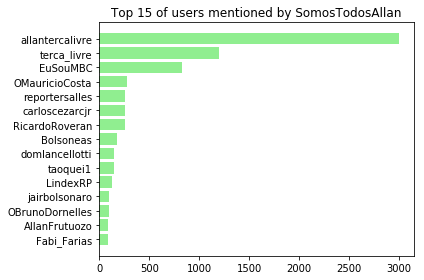

In [189]:
##################################################################
# Plot users mentioned by hashtag: SomosTodosAllan
##################################################################
my_tweets.rewind()
user = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        if 'SomosTodosAllan' in [e['text'] for e in t['entities']['hashtags']]:
            u = e['screen_name']
            user.append(u)
D = Counter(user)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'lightgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned by SomosTodosAllan')
plt.tight_layout()
plt.show()

So as mentioned, most of the users mentioned with the hashtag SomosTodosAllan are those related to the brazilian accounts and politics. 

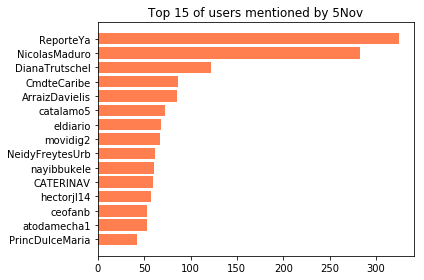

In [182]:
##################################################################
# Plot users mentioned by hashtag: 5Nov
##################################################################
my_tweets.rewind()
user = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        if '5Nov' in [e['text'] for e in t['entities']['hashtags']]:
            u = e['screen_name']
            user.append(u)
D = Counter(user)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'coral')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned by 5Nov')
plt.tight_layout()
plt.show()

Of the top users mentioned in 5Nov was NicolasMaduro, considering that the 5Nov was the most popular hashtag captured for tweets that had location and were in Venezuela. The user is probably mentioned in other hashtags as well, since ReporteYa (a Venezuelan news site) has more mentions in the 5Nov hashtag. 

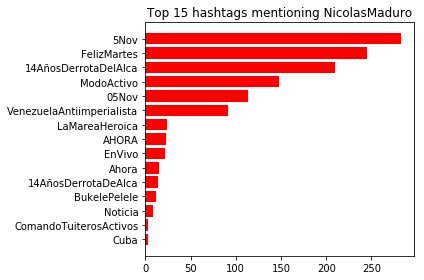

In [190]:
##################################################################
# Plot hashtags for user NicolasMaduro
##################################################################
my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        if e['screen_name'] == 'NicolasMaduro':
            for h in t['entities']['hashtags']:
                hashList.append(h['text'])

D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'red')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 hashtags mentioning NicolasMaduro')
plt.tight_layout()
plt.show()

As mentioned before, NicolasMaduro is also popular in other hashtags captured like "FelizMartes"

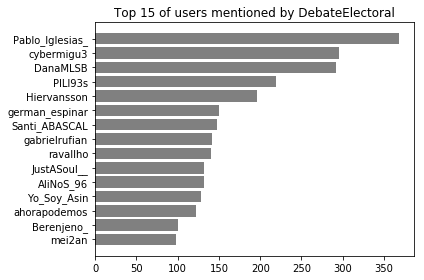

In [183]:
##################################################################
# Plot users mentioned by hashtag: DebateElectoral
##################################################################
my_tweets.rewind()
user = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        if 'DebateElectoral' in [e['text'] for e in t['entities']['hashtags']]:
            u = e['screen_name']
            user.append(u)
D = Counter(user)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'grey')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned by DebateElectoral')
plt.tight_layout()
plt.show()

The DebateElectoral hashtag also has alot of users related to politics like gabrielrufian and ahorapodemos.

## Conclusion

Capturing data from twitter via the API can be helpful to analyse trending topics and the users related which can be used to study publicity campaings or political issues. In these experiments we were able to detect current events in K-pop culture and the reach that these events had, and also track down political events in Brazil, Spain, US and Venezuela. Unfortunately, most tweets don't have location activated, with only a few hundred of them being captured out of the more than 200k tweets found.

Storing data in MongoDB is very simple, as we don't have to worry about formatting the data when we gather it, rather, just by turning it into json we can insert it directly into the database. This allows us to store large volumes of data as fast as possible and then focus on formatting when we are going to analyse it. Also, it was possible to store more than 200k tweets and the retrieval was still very fast and efficient, but for larger amount of records, MongoDB provides ways to query the data so that we get only the data we are interested in. 